# Advanced Tables for JWST


# Table design goals and requirements

- Easily mutable container of heterogeneous tabular data
- Relatively lightweight yet powerful enough for most needs
- Responsive to astronomy community needs
  - For JWST community - if something is missing, broken, needs improvement then ASK!
- Deep integration with Astropy (I/O, units, quantity)
- Persistent metadata (column units, table header keywords, formatting)
- Support missing data

# Why doesn't Astropy use Pandas DataFrame?

- Easily mutable container of heterogeneous tabular data **(only scalar data)**
- **Relatively lightweight** yet powerful enough for most needs
- Responsive to **astronomy community** needs
- **Deep integration with Astropy (I/O, units, quantity)**
- **Persistent metadata (column units, table header keywords, formatting)**
- Support missing data: **Pandas will cast ``int`` types to ``float64`` to use ``NaN``**
  - Large ``int64`` values lose precision
  - Short int (e.g. ``uint8``) values take 4 times as much memory as ``MaskedColumn``

### Nevertheless...

We recognize Pandas is very fast, powerful and widely used.

*Astropy Project recommendation is to use `astropy.Table` where possible.  This especially applies to community packages.*


# Example: multiband photometry of a field

### Observations in 5 bands of a single field with 5 "galaxy-like" sources

- Assumes basic image reduction and source detection is done.
- Could be similar to JWST post-image processing workflow.

### Key Table concepts to be covered

- Basic table structure (dict of independent column objects)
- Base column class properties and attributes (flexibility in data elements)
- Table mutability and formatting
- Database operations: join, grouping, binning, stacking, indexing
- Missing data
- Mixin columns (Quantity, Time, Coordinates, QTable vs. Table)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy
from astropy import table
from astropy.table import Column, Table, QTable
from astropy.time import Time
import astropy.units as u
import photutils.datasets
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
astropy.__version__

'3.1'

### Make table of  5 random gaussians corresponding to fake elliptical galaxy-like sources

Use a photutils utility function [make_random_gaussians_table](https://photutils.readthedocs.io/en/stable/api/photutils.datasets.make_random_gaussians_table.html).

In [3]:
n_sources = 5
param_ranges = dict([('flux', [1000, 10000]),
                ('x_mean', [10, 190]),
                ('y_mean', [10, 190]),
                ('x_stddev', [2, 5]), 
                ('y_stddev', [2, 5]),
                ('theta', [0, np.pi])])
sources = photutils.datasets.make_random_gaussians_table(n_sources, param_ranges, random_state = 1)

In [4]:
sources

flux,x_mean,y_mean,x_stddev,y_stddev,theta,amplitude
float64,float64,float64,float64,float64,float64,float64
4753.198042323166,26.620947058383603,85.45501259259306,4.011402530535207,4.40223370602661,2.810489721916163,42.838741361618546
7482.920440979423,43.52683804798076,133.33951007141673,3.251914407101381,4.904784727158193,0.26717426966963187,74.6676017675449
1001.029373356104,72.2009308677486,46.801404951673135,3.676069485337255,2.9402725344777285,0.12269422009196505,14.739937902337719
3720.993153686558,81.41814536152059,168.06113855037017,2.421160815785701,4.076967847007943,0.533537998460122,59.9954174544474
2320.8030173540174,106.98701212060425,14.92976677562671,2.5943044672546365,4.629167456888115,2.758766037578794,30.7563346178988


### Digression: learn a little about the Table and Column objects

- `Table` is a **container class** where `Table.columns` is the main table data structure
- `Table.columns` is an OrderedDict of columns (`Column`, `MaskedColumn`, or mixin-column)
- `Column` class inherits from `np.ndarray`
- `MaskedColumn` class inherits from `np.ma.MaskedArray`

In [5]:
type(sources.columns).__mro__

(astropy.table.table.TableColumns, collections.OrderedDict, dict, object)

In [6]:
type(sources.columns['flux']).__mro__

(astropy.table.column.Column,
 astropy.table.column.BaseColumn,
 astropy.table._column_mixins._ColumnGetitemShim,
 numpy.ndarray,
 object)

In [7]:
sources.columns['flux'] is sources['flux']

True

### Make a synthetic image for cutouts

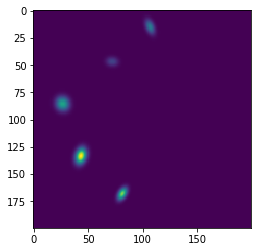

In [8]:
img = photutils.datasets.make_gaussian_sources_image(shape=(200, 200), 
                                               source_table=sources)
plt.imshow(img);  # Trick: trailing semicolon to suppress output

### Make postage-stamp cutouts for each source

In [9]:
# Make integer columns with rounded representation of source mean position 

sources['x0'] = np.round(sources['x_mean']).astype(int)
sources['y0'] = np.round(sources['y_mean']).astype(int)

In [10]:
# Generate list of cutout images around each source

npix = 10
cutouts = [img[y0-npix:y0+npix, x0-npix:x0+npix] for x0, y0 in sources['x0', 'y0']]

# `cutouts` is a list of 2-d ndarrays

In [11]:
# Add the cutouts into table: each element is a 2-d image
# This shows:
#  - Table mutability and independent columns
#  - Storage of ndarray in each table cell

sources['cutout'] = cutouts

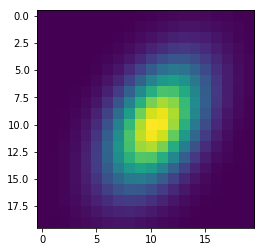

In [12]:
plt.imshow(sources['cutout'][3], interpolation='nearest');

### Add a source identifier to the table

In [13]:
sources['id'] = ['jwst-{}-{}'.format(x0, y0) for x0, y0 in sources['x0', 'y0']]
sources

flux,x_mean,y_mean,x_stddev,y_stddev,theta,amplitude,x0,y0,"cutout [20,20]",id
float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,str11
4753.198042323166,26.620947058383603,85.45501259259306,4.011402530535207,4.40223370602661,2.810489721916163,42.838741361618546,27,85,0.1974786837807795 .. 0.5534277029271929,jwst-27-85
7482.920440979423,43.52683804798076,133.33951007141673,3.251914407101381,4.904784727158193,0.26717426966963187,74.6676017675449,44,133,0.028459677466553535 .. 0.0766241752683345,jwst-44-133
1001.029373356104,72.2009308677486,46.801404951673135,3.676069485337255,2.9402725344777285,0.12269422009196505,14.739937902337719,72,47,0.0020048959858209167 .. 0.009505383995544379,jwst-72-47
3720.993153686558,81.41814536152059,168.06113855037017,2.421160815785701,4.076967847007943,0.533537998460122,59.9954174544474,81,168,1.901989494354942e-06 .. 0.00022714439589234747,jwst-81-168
2320.8030173540174,106.98701212060425,14.92976677562671,2.5943044672546365,4.629167456888115,2.758766037578794,30.7563346178988,107,15,0.062406969945736475 .. 0.19228454779415236,jwst-107-15


### Formatting: let's be a little fussy about the Table:
- Put the 'id' column first
- Make the precision of table outputs more reasonable (and beautiful!)
- Add units to `flux` and `theta` columns



In [14]:
# Move the `id` column to be the first column 
# (Should Table get a method `move_column` to make this easier?)
sources_id = sources['id']
del sources['id']
sources.add_column(sources_id, index=0)

# Set the output formatting for particular columns
for name in ('flux', 'x_mean', 'y_mean', 'x_stddev', 'y_stddev', 'theta'):
    sources[name].format = '.3f'  # Could also use '%.3f' or '{:.3f}'
sources['cutout'].format = '.3g'

# Set the unit for flux and theta
sources['flux'].unit = u.electron
sources['theta'].unit = u.rad

sources

id,flux,x_mean,y_mean,x_stddev,y_stddev,theta,amplitude,x0,y0,"cutout [20,20]"
,electron,,,,,rad,,,,
str11,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-27-85,4753.198,26.621,85.455,4.011,4.402,2.810,42.838741361618546,27,85,0.197 .. 0.553
jwst-44-133,7482.920,43.527,133.340,3.252,4.905,0.267,74.6676017675449,44,133,0.0285 .. 0.0766
jwst-72-47,1001.029,72.201,46.801,3.676,2.940,0.123,14.739937902337719,72,47,0.002 .. 0.00951
jwst-81-168,3720.993,81.418,168.061,2.421,4.077,0.534,59.9954174544474,81,168,1.9e-06 .. 0.000227
jwst-107-15,2320.803,106.987,14.930,2.594,4.629,2.759,30.7563346178988,107,15,0.0624 .. 0.192


### Digression: table and column summary information

In [15]:
sources.info

<Table length=5>
   name    dtype   shape     unit   format
--------- ------- -------- -------- ------
       id   str11                         
     flux float64          electron    .3f
   x_mean float64                      .3f
   y_mean float64                      .3f
 x_stddev float64                      .3f
 y_stddev float64                      .3f
    theta float64               rad    .3f
amplitude float64                         
       x0   int64                         
       y0   int64                         
   cutout float64 (20, 20)             .3g

In [16]:
sources.info('stats')
# You can write your own info specifications!

<Table length=5>
   name          mean               std                  min                 max        
--------- ------------------ ------------------ --------------------- ------------------
       id                 --                 --                    --                 --
     flux 3855.7888055398535  2212.936053861641     1001.029373356104  7482.920440979423
   x_mean  66.15077469124756 28.325765889920238    26.620947058383603 106.98701212060425
   y_mean  89.71736658833596  55.66645402363652     14.92976677562671 168.06113855037017
 x_stddev  3.190970341202836 0.6100428192607832     2.421160815785701  4.011402530535207
 y_stddev  4.190685254311718 0.6816774992861885    2.9402725344777285  4.904784727158193
    theta 1.2985324495433352 1.2206398872991027   0.12269422009196505  2.810489721916163
amplitude  44.59960662076947 21.106643340681835    14.739937902337719   74.6676017675449
       x0               66.2 28.095551249263647                    27                107
    

In [17]:
# You can roll your own custom info!

from astropy.utils.data_info import data_info_factory
mystats = data_info_factory(names=['my_min', 'my_median', 'my_max'],
                            funcs=[np.min, np.median, np.max])
sources.info(mystats)

<Table length=5>
   name           my_min            my_median            my_max      
--------- --------------------- ------------------ ------------------
       id                    --                 --                 --
     flux     1001.029373356104  3720.993153686558  7482.920440979423
   x_mean    26.620947058383603   72.2009308677486 106.98701212060425
   y_mean     14.92976677562671  85.45501259259306 168.06113855037017
 x_stddev     2.421160815785701  3.251914407101381  4.011402530535207
 y_stddev    2.9402725344777285   4.40223370602661  4.904784727158193
    theta   0.12269422009196505  0.533537998460122  2.810489721916163
amplitude    14.739937902337719 42.838741361618546   74.6676017675449
       x0                    27               72.0                107
       y0                    15               85.0                168
   cutout 1.901989494354942e-06  3.470181826068183  73.87936011733294


#### Column info: name, dtype, unit, format, description

In [18]:
sources['theta'].info.description = 'Elliptical gaussian rotation angle'
sources['theta'].info

name = theta
dtype = float64
unit = rad
format = .3f
description = Elliptical gaussian rotation angle
class = Column
n_bad = 0
length = 5

### Make fake observations of these sources in 5 bands 'u', 'b', 'v', 'r', 'k'

In [19]:
def make_observation(sources, band, flux_mult):
    """
    Make fake observation of ``sources`` in a field in ``band``.  Apply
    ``flux_mult`` flux multiplier and some gaussian noise on parameters.
    """
    n = len(sources)
    out = sources.copy()

    # Multiply flux by randomized version of flux_mult
    out['flux'] *= flux_mult * np.random.normal(loc=1, scale=0.1, size=n)

    # Add 1.0 pixel of position and stddev noise
    for name in ('x_mean', 'y_mean'):
        out[name] += np.random.normal(loc=0, scale=1.0, size=n)
  
    # Add 0.1 pixel noise to stddev
    for name in ('x_stddev', 'y_stddev'):
        out[name] += np.random.normal(loc=0, scale=0.1, size=n)
        
    # Add a list that repeats the ``band`` as the second column
    out.add_column(Column([band] * n, name='band'), index=1)
    
    # Make integer columns with rounded representation of source mean position  
    sources['x0'] = np.round(sources['x_mean']).astype(int)
    sources['y0'] = np.round(sources['y_mean']).astype(int)
    
    # Generate list of cutout images around each source
    img = photutils.datasets.make_gaussian_sources_image(shape=(200, 200), source_table=out)
    npix = 10
    cutouts = [img[y0-npix:y0+npix, x0-npix:x0+npix] for x0, y0 in sources['x0', 'y0']]
    sources['cutout'] = cutouts

    return out

In [20]:
sources_list = []
for band, flux_mult in [('u', 0.1), 
                        ('b', 0.2), 
                        ('v', 0.5), 
                        ('r', 1.0), 
                        ('k', 1.5)]:
    sources_list.append(make_observation(sources, band, flux_mult))
    
sources_list[0]

# Notice that the formatting and units got inherited into our new tables

id,band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,amplitude,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,,
str11,str1,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-27-85,u,440.951,28.706,84.967,4.188,4.451,2.810,42.838741361618546,27,85,0.197 .. 0.553
jwst-44-133,u,689.202,43.758,134.607,3.281,4.838,0.267,74.6676017675449,44,133,0.0285 .. 0.0766
jwst-72-47,u,93.226,72.742,48.954,3.757,3.050,0.123,14.739937902337719,72,47,0.002 .. 0.00951
jwst-81-168,u,394.393,82.590,168.416,2.326,4.169,0.534,59.9954174544474,81,168,1.9e-06 .. 0.000227
jwst-107-15,u,249.535,107.259,14.344,2.706,4.603,2.759,30.7563346178988,107,15,0.0624 .. 0.192


In [21]:
# Pretend that there are non-detections in some bands

sources_list[0].remove_rows([1,2,3,4])
sources_list[1].remove_row(1)
sources_list[3].remove_row(0)

## Database-like features for more power: vstack, indexing, group and join

Our list of source tables **`sources_list`** has the raw data we need for analysis but is inconvenient.  Things we'd like to do:

- Find all observations of a particular source
- List all sources in a particular band
- Compute statistics for a particular source (mean centroid, mean image cutout)
- Make a single wide table organized by source

See [Table high-level operations](http://docs.astropy.org/en/stable/table/operations.html) for all the details.

### Stacking

In [22]:
# Stack the list of tables to create a single table (database) of every source observation.

srcs = table.vstack(sources_list)

srcs

id,band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,amplitude,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,,
str11,str1,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-27-85,u,440.951,28.706,84.967,4.188,4.451,2.810,42.838741361618546,27.000,85.000,0.197 .. 0.553
jwst-27-85,b,945.228,25.854,86.626,3.992,4.398,2.810,42.838741361618546,27.000,85.000,0.0898 .. 1.35
jwst-72-47,b,156.861,72.064,47.517,3.489,2.797,0.123,14.739937902337719,72.000,47.000,0.000204 .. 0.118
jwst-81-168,b,708.464,81.362,168.380,2.335,4.063,0.534,59.9954174544474,81.000,168.000,1.95e-08 .. 0.00095
jwst-107-15,b,453.704,108.084,13.411,2.675,4.730,2.759,30.7563346178988,107.000,15.000,0.0646 .. 0.227
jwst-27-85,v,2215.543,27.097,85.632,3.927,4.498,2.810,42.838741361618546,27.000,85.000,0.153 .. 0.551
jwst-44-133,v,3940.358,41.012,133.555,3.325,4.938,0.267,74.6676017675449,44.000,133.000,0.0214 .. 0.0578
jwst-72-47,v,447.794,71.881,45.327,3.647,2.895,0.123,14.739937902337719,72.000,47.000,0.000353 .. 0.00847


### Indexing

- Indexing means that supplemental information (an index) is added to the table that allows access to particular elements in `time << O(N)`.  
- In the case of astropy Table it uses a binary search of an ordered index table `O(log(N))`.

In [23]:
# Now add a database index on the `id` column.  This becomes the 'primary key'.
# In this case it does not need to be unique, though one can declare that an
# index must be unique.

srcs.add_index('id')

In [24]:
# Now access elements with id == 'jwst-27-85'.  This should be familiar to Pandas users.
# This returns another Table.

srcs.loc['jwst-27-85']

id,band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,amplitude,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,,
str11,str1,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-27-85,v,2215.543,27.097,85.632,3.927,4.498,2.810,42.838741361618546,27.000,85.000,0.153 .. 0.551
jwst-27-85,b,945.228,25.854,86.626,3.992,4.398,2.810,42.838741361618546,27.000,85.000,0.0898 .. 1.35
jwst-27-85,k,6754.420,26.824,85.473,4.049,4.561,2.810,42.838741361618546,27.000,85.000,0.249 .. 0.282
jwst-27-85,u,440.951,28.706,84.967,4.188,4.451,2.810,42.838741361618546,27.000,85.000,0.197 .. 0.553


In [25]:
# Let's make a secondary index to allow slicing the table by band
srcs.add_index('band')

In [26]:
# Get a table of all 'b' band source detections

srcs.loc['band', 'b']

id,band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,amplitude,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,,
str11,str1,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-27-85,b,945.228,25.854,86.626,3.992,4.398,2.810,42.838741361618546,27.000,85.000,0.0898 .. 1.35
jwst-72-47,b,156.861,72.064,47.517,3.489,2.797,0.123,14.739937902337719,72.000,47.000,0.000204 .. 0.118
jwst-81-168,b,708.464,81.362,168.380,2.335,4.063,0.534,59.9954174544474,81.000,168.000,1.95e-08 .. 0.00095
jwst-107-15,b,453.704,108.084,13.411,2.675,4.730,2.759,30.7563346178988,107.000,15.000,0.0646 .. 0.227


In [27]:
# A special case is if only one table row is selected, in which case
# a Row object is returned.  This is convenient for the common use case
# of a table with unique keys.

srcs.loc['band', 'u']

id,band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,amplitude,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,,
str11,str1,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-27-85,u,440.951,28.706,84.967,4.188,4.451,2.810,42.838741361618546,27.000,85.000,0.197 .. 0.553


### Digression: difference between Row and length=1 Table

- Indexing a single element of a table returns a `Row` object which can be used to set or access a column value.  This always returns a scalar value.
- Indexing a single row slice of a table returns a Table, so accessing a column returns a `Column` object (an array) with a length of 1.
- This is consistent with numpy structured arrays and Pandas (`df.ix[0]` vs. `df[0:1]`).

In [28]:
srcs[0]['band']

'u'

In [29]:
srcs[0:1]['band']

u


### Digression: table access performance

**``srcs[0:1]['band']``** and **``srcs['band'][0:1]``** give the same output, but performance is very different!

In [30]:
# This creates an entire new Table object (slow) and then selects one column (fast)
%timeit srcs[0:1]['band']

749 µs ± 4.01 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [31]:
# This selects a column (fast) and then slices it (fast-ish, creates new Column)
%timeit srcs['band'][0:1]

23.3 µs ± 361 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [32]:
# For the most performance, drop the `Column` machinery (no metadata) and use a straight numpy array

%timeit np.array(srcs['band'], copy=False)[0:1]

1.69 µs ± 14.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


### Grouping

Astropy `Table` supports the powerful concept of grouping which lets you group the rows into sub-tables which you can then:

- [Examine](http://docs.astropy.org/en/stable/table/operations.html#manipulating-groups): select and loop over groups
- [Aggregate](http://docs.astropy.org/en/stable/table/operations.html#aggregation): apply a reduction function like np.mean to each group
- [Filter](http://docs.astropy.org/en/stable/table/operations.html#filtering): select groups by means a selection function

This is a close cousin to indexing, and if a table is already indexed then creating the grouped version is faster.

In [33]:
srcs_grouped = srcs.group_by('id')

# srcs_grouped has all the same rows but now ordered by ``id``
srcs_grouped

id,band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,amplitude,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,,
str11,str1,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-107-15,v,1305.174,106.559,14.750,2.590,4.589,2.759,30.7563346178988,107.000,15.000,0.0361 .. 0.359
jwst-107-15,r,2863.761,107.951,14.741,2.707,4.663,2.759,30.7563346178988,107.000,15.000,0.0919 .. 0.116
jwst-107-15,b,453.704,108.084,13.411,2.675,4.730,2.759,30.7563346178988,107.000,15.000,0.0646 .. 0.227
jwst-107-15,k,3378.575,105.841,15.331,2.593,4.780,2.759,30.7563346178988,107.000,15.000,0.0322 .. 0.467
jwst-27-85,v,2215.543,27.097,85.632,3.927,4.498,2.810,42.838741361618546,27.000,85.000,0.153 .. 0.551
jwst-27-85,b,945.228,25.854,86.626,3.992,4.398,2.810,42.838741361618546,27.000,85.000,0.0898 .. 1.35
jwst-27-85,k,6754.420,26.824,85.473,4.049,4.561,2.810,42.838741361618546,27.000,85.000,0.249 .. 0.282
jwst-27-85,u,440.951,28.706,84.967,4.188,4.451,2.810,42.838741361618546,27.000,85.000,0.197 .. 0.553


In [34]:
for src in srcs_grouped.groups:
    print(src)

     id     band   flux    x_mean ...    x0     y0    cutout [20,20]
                 electron         ...                               
----------- ---- -------- ------- ... ------- ------ ---------------
jwst-107-15    v 1305.174 106.559 ... 107.000 15.000 0.0361 .. 0.359
jwst-107-15    r 2863.761 107.951 ... 107.000 15.000 0.0919 .. 0.116
jwst-107-15    b  453.704 108.084 ... 107.000 15.000 0.0646 .. 0.227
jwst-107-15    k 3378.575 105.841 ... 107.000 15.000 0.0322 .. 0.467
    id     band   flux   x_mean ...   x0     y0   cutout [20,20]
                electron        ...                             
---------- ---- -------- ------ ... ------ ------ --------------
jwst-27-85    v 2215.543 27.097 ... 27.000 85.000 0.153 .. 0.551
jwst-27-85    b  945.228 25.854 ... 27.000 85.000 0.0898 .. 1.35
jwst-27-85    k 6754.420 26.824 ... 27.000 85.000 0.249 .. 0.282
jwst-27-85    u  440.951 28.706 ... 27.000 85.000 0.197 .. 0.553
     id     band   flux   x_mean ...   x0      y0    cutout [2

In [35]:
# Now let's make a new table where each row is the mean of all rows in the group
mean_srcs = srcs_grouped.groups.aggregate(np.mean)
mean_srcs

id,flux,x_mean,y_mean,x_stddev,y_stddev,theta,amplitude,x0,y0
,electron,,,,,rad,,,
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64
jwst-107-15,2000.304,107.109,14.558,2.641,4.691,2.759,30.7563346178988,107.000,15.000
jwst-27-85,2589.036,27.120,85.675,4.039,4.477,2.810,42.838741361618546,27.000,85.000
jwst-44-133,6396.198,42.866,134.017,3.365,4.993,0.267,74.6676017675449,44.000,133.000
jwst-72-47,752.349,71.680,46.290,3.618,2.882,0.123,14.739937902337719,72.000,47.000
jwst-81-168,3196.240,82.053,168.097,2.467,4.079,0.534,59.9954174544474,81.000,168.000


In [36]:
# We can define custom behavior depending on column type or even name

def sources_mean(arr):
    if arr.dtype.kind in ('S', 'U'):
        out= ', '.join(arr)
    elif arr.info.name == 'flux':
        # Take the log mean
        out = np.exp(np.mean(np.log(arr)))
    else:
        out = np.mean(arr, axis=0)

    return out

In [37]:
mean_srcs = srcs_grouped.groups.aggregate(sources_mean)
mean_srcs

id,band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,amplitude,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,,
str11,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
jwst-107-15,"v, r, b, k",1547.134,107.109,14.558,2.641,4.691,2.759,30.7563346178988,107.000,15.000,0.0562 .. 0.292
jwst-27-85,"v, b, k, u",1580.334,27.120,85.675,4.039,4.477,2.810,42.838741361618546,27.000,85.000,0.172 .. 0.685
jwst-44-133,"v, r, k",6077.825,42.866,134.017,3.365,4.993,0.267,74.6676017675449,44.000,133.000,0.121 .. 0.063
jwst-72-47,"b, v, r, k",555.146,71.680,46.290,3.618,2.882,0.123,14.739937902337719,72.000,47.000,0.00348 .. 0.0331
jwst-81-168,"v, k, r, b",2371.557,82.053,168.097,2.467,4.079,0.534,59.9954174544474,81.000,168.000,1.01e-05 .. 0.00087


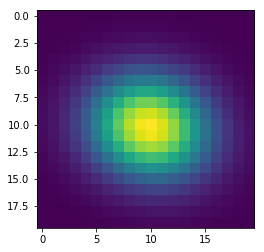

In [38]:
plt.imshow(mean_srcs['cutout'][3], interpolation='nearest')

### Digression: Binning

A common tool in analysis is to **bin** a table based on some reference value. Examples:

- Photometry of a binary star in several bands taken over a span of time which should be binned by orbital phase.
- Reducing the sampling density for a table by combining 100 rows at a time.
- Unevenly sampled historical data which should binned to four points per year.

The common theme in all these cases is to convert the key value array into a 
new `float`- or `int`-valued array whose values are identical for rows in the same output bin. As an example, generate a fake light curve:


In [39]:
year = np.linspace(2000.0, 2010.0, 200)  # 200 observations over 10 years
period = 1.811
y0 = 2005.2
mag = 14.0 + 1.2 * np.sin(2 * np.pi * (year - y0) / period) + np.random.normal(scale=0.1, size=200)
phase = ((year - y0) / period) % 1.0
dat = Table([year, phase, mag], names=['year', 'phase', 'mag'])

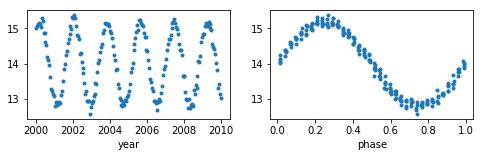

In [40]:
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(dat['year'], dat['mag'], '.')
plt.xlabel('year')
plt.subplot(1, 2, 2)
plt.xlabel('phase')
plt.plot(dat['phase'], dat['mag'], '.');

In [41]:
phase_bin = np.trunc(phase / 0.1)
phase_bin[:50]

array([1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 4., 4., 4., 4., 5., 5., 5.,
       6., 6., 6., 6., 7., 7., 7., 7., 8., 8., 8., 9., 9., 9., 9., 0., 0.,
       0., 0., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 4., 4., 4., 4.])

In [42]:
dat_grouped = dat.group_by(phase_bin)
dat_mean = dat_grouped.groups.aggregate(np.mean)
dat_std = dat_grouped.groups.aggregate(np.std)

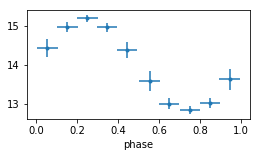

In [43]:
plt.figure(figsize=(4, 2))
plt.xlabel('phase')
plt.errorbar(x=dat_mean['phase'], xerr=0.05, y=dat_mean['mag'], yerr=dat_std['mag'], fmt='.');

### Join tables to make a single wide table by source `id`

- Have one row corresponding to each of the 5 sources
- Each row has columns with the 5 band u, b, v, r, k properties
- De-duplicate column names by labeling as `{colname}_{band}`

Because there are non-detections for some bands / sources, the result is a **Masked Table**.

In [44]:
sources_id = None
for left, right in zip(sources_list[:-1], sources_list[1:]):
    sources_id = table.join(left=sources_id or left,
                            right=right,
                            keys='id',
                            join_type='outer',
                            table_names=[left['band'][0], right['band'][0]])
sources_id

id,band_u,flux_u,x_mean_u,y_mean_u,x_stddev_u,y_stddev_u,theta_u,amplitude_u,x0_u,y0_u,"cutout_u [20,20]",band_b,flux_b,x_mean_b,y_mean_b,x_stddev_b,y_stddev_b,theta_b,amplitude_b,x0_b,y0_b,"cutout_b [20,20]",band_v,flux_v,x_mean_v,y_mean_v,x_stddev_v,y_stddev_v,theta_v,amplitude_v,x0_v,y0_v,"cutout_v [20,20]",band_r,flux_r,x_mean_r,y_mean_r,x_stddev_r,y_stddev_r,theta_r,amplitude_r,x0_r,y0_r,"cutout_r [20,20]",band,flux,x_mean,y_mean,x_stddev,y_stddev,theta,amplitude,x0,y0,"cutout [20,20]"
,,electron,,,,,rad,,,,,,electron,,,,,rad,,,,,,electron,,,,,rad,,,,,,electron,,,,,rad,,,,,,electron,,,,,rad,,,,
str11,str1,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,str1,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,str1,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,str1,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,str1,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-107-15,--,--,--,--,--,--,--,--,--,--,-- .. --,b,453.704,108.084,13.411,2.675,4.730,2.759,30.7563346178988,107.000,15.000,0.0645757447268112 .. 0.22717782336758202,v,1305.174,106.559,14.750,2.590,4.589,2.759,30.7563346178988,107.000,15.000,0.03610127766564468 .. 0.35899837745483554,r,2863.761,107.951,14.741,2.707,4.663,2.759,30.7563346178988,107.000,15.000,0.09187703442821014 .. 0.11646616576922734,k,3378.575,105.841,15.331,2.593,4.780,2.759,30.7563346178988,107.000,15.000,0.03215395861348415 .. 0.4669816972386961
jwst-27-85,u,440.951,28.706,84.967,4.188,4.451,2.810,42.838741361618546,27,85,0.197 .. 0.553,b,945.228,25.854,86.626,3.992,4.398,2.810,42.838741361618546,27.000,85.000,0.08983740164810348 .. 1.3548739878802885,v,2215.543,27.097,85.632,3.927,4.498,2.810,42.838741361618546,27.000,85.000,0.15251316594298464 .. 0.5512375916662589,--,--,--,--,--,--,--,--,--,--,-- .. --,k,6754.420,26.824,85.473,4.049,4.561,2.810,42.838741361618546,27.000,85.000,0.2491401565267816 .. 0.28156684052569025
jwst-44-133,--,--,--,--,--,--,--,--,--,--,-- .. --,--,--,--,--,--,--,--,--,--,--,-- .. --,v,3940.358,41.012,133.555,3.325,4.938,0.267,74.6676017675449,44.000,133.000,0.021391616459778325 .. 0.05777194433458016,r,6552.223,42.412,135.162,3.439,4.886,0.267,74.6676017675449,44.000,133.000,0.29153728604562984 .. 0.008251435904978668,k,8696.013,45.175,133.334,3.332,5.155,0.267,74.6676017675449,44.000,133.000,0.049598543460652296 .. 0.12291589165083872
jwst-72-47,--,--,--,--,--,--,--,--,--,--,-- .. --,b,156.861,72.064,47.517,3.489,2.797,0.123,14.739937902337719,72.000,47.000,0.00020368096043959892 .. 0.11765149984933077,v,447.794,71.881,45.327,3.647,2.895,0.123,14.739937902337719,72.000,47.000,0.0003525895567093823 .. 0.0084669840635124,r,896.576,70.625,47.146,3.713,2.941,0.123,14.739937902337719,72.000,47.000,0.00922529384910719 .. 0.0012304264812425005,k,1508.166,72.149,45.170,3.622,2.894,0.123,14.739937902337719,72.000,47.000,0.004130714918421705 .. 0.005130975515479062
jwst-81-168,--,--,--,--,--,--,--,--,--,--,-- .. --,b,708.464,81.362,168.380,2.335,4.063,0.534,59.9954174544474,81.000,168.000,1.953783161959989e-08 .. 0.0009503301876350062,v,1812.206,82.773,168.190,2.433,4.038,0.534,59.9954174544474,81.000,168.000,3.6987307840604426e-07 .. 0.00012316977897002232,r,3828.025,80.514,167.581,2.480,4.119,0.534,59.9954174544474,81.000,168.000,1.161566926098353e-07 .. 0.0023537956965316263,k,6436.263,83.563,168.236,2.621,4.095,0.534,59.9954174544474,81.000,168.000,3.9979805464943574e-05 .. 5.139217368599243e-05


In [45]:
# Inspect a masked element

sources_id.add_index('id')
sources_id.loc['jwst-44-133']['flux_u'] is np.ma.masked

True

## Astropy integration: quantities, units, mixin columns, QTable and all that

A major feature of astropy `Table` is integrated support for:

- ``Quantity`` columns that have meaningful units
- ``Time`` and ``Coordinate`` columns
- Other "mixin columns"

Mixin columns are object types that adhere to the mixin protocol and are
stored and manipulated **natively** in the table.

### Example: store a Time object in a table

In [46]:
t = Table()
t['index'] = [1, 2]
t['time'] = Time(['2001-01-02T12:34:56', '2001-02-03T00:01:02'])
t

index,time
int64,object
1,2001-01-02T12:34:56.000
2,2001-02-03T00:01:02.000


In [47]:
# The time column is a bona-fide Time object
t['time']

<Time object: scale='utc' format='isot' value=['2001-01-02T12:34:56.000' '2001-02-03T00:01:02.000']>

In [48]:
# In case you don't believe me
t['time'].mjd

array([51911.52425926, 51943.00071759])

### Quantity: doesn't Table already support units?

We saw in the `sources` table that we can define unit.  Aren't we good to go?  **No**

In [49]:
type(sources['theta'])

astropy.table.column.Column

In [50]:
sources['theta'].unit

Unit("rad")

**Normal table `Column` class is just carrying `unit` as an attribute.**

It is no more special than `description` or `format`:

In [51]:
t2 = sources['theta'] ** 2
t2.unit

Unit("rad")

### QTable to the rescue

Astropy has a `QTable` class for tables that use `Quantity` objects for columns with units.

See the [Quantity and QTable](http://docs.astropy.org/en/stable/table/mixin_columns.html#quantity-and-qtable) section for more details.

In [52]:
# Let's make `flux` and `theta` be real Quantity objects!
qsources = QTable(sources)
qsources

id,flux,x_mean,y_mean,x_stddev,y_stddev,theta,amplitude,x0,y0,"cutout [20,20]"
,electron,,,,,rad,,,,
str11,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64
jwst-27-85,4753.198,26.621,85.455,4.011,4.402,2.810,42.838741361618546,27.000,85.000,0.24111778543497306 .. 0.7875752770332544
jwst-44-133,7482.920,43.527,133.340,3.252,4.905,0.267,74.6676017675449,44.000,133.000,0.008010986299847568 .. 0.454957871272218
jwst-72-47,1001.029,72.201,46.801,3.676,2.940,0.123,14.739937902337719,72.000,47.000,0.008252600048426251 .. 0.0011332174824851481
jwst-81-168,3720.993,81.418,168.061,2.421,4.077,0.534,59.9954174544474,81.000,168.000,3.842269149142789e-07 .. 0.023993745529687714
jwst-107-15,2320.803,106.987,14.930,2.594,4.629,2.759,30.7563346178988,107.000,15.000,0.20016888913629313 .. 0.08334167259853724


*The repeated presence of `electron` and `rad` in each Quantity value is a problem that is fixed in 1.3-dev*.

In [53]:
type(qsources['theta'])

astropy.units.quantity.Quantity

In [54]:
qt2 = qsources['theta'] ** 2
qt2.unit

Unit("rad2")

### Summary of `Table` and `QTable`

In short, `Table` and `QTable` are **identical in every way except for handling columns with units**:
- `Table` uses `Column` for any columns with units (with informational-only unit attribute)
- `QTable` uses `Quantity` for any columns with units (with meaningful unit attribute)

Use `QTable` in general if you are fully on-board with using `Quantity` and do not deal with much legacy code.

Use `Table` if you are using code that is not `Quantity`-aware, OR if you need full missing data support.  `Quantity` does not support missing (masked) data.

### Digression: storing a Pandas Series within Astropy Table

In [55]:
from astropy.utils.data_info import ParentDtypeInfo
import pandas as pd

class SeriesMixin(pd.Series):
    info = ParentDtypeInfo()

In [56]:
s = SeriesMixin((np.arange(5)-2)**2)
pt = Table([s], names=['s'])

In [57]:
pt['s'].info

name = s
dtype = int64
class = SeriesMixin
n_bad = 1
length = 5

In [58]:
isinstance(pt['s'], pd.Series)

True

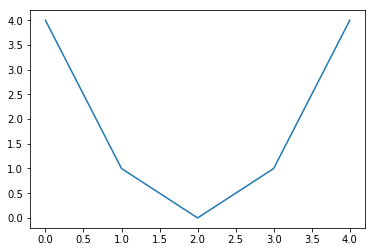

In [59]:
pt['s'].plot();

## But wait, there's more... for another day

- Transform to/from other table-like objects (Pandas DataFrame, numpy structured array, LSST)
- Subclass for custom applications (documentation example of params)
- Unified interface for I/O (ASCII, FITS, votable)